# Required Libraries

In [76]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import normalize, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.decomposition import PCA
import itertools

# Step 1: first importing the Data

In [78]:
data = np.genfromtxt("winequality-red-4.csv", delimiter=";", skip_header=1)

# column names for better visualizations
column_names = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
    "quality",
]

# Step 2: cleaning the data and Train-Test Split

In [80]:
X, y = data[:, :-1], data[:, -1]
X = normalize(X, axis=0) 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Step 3: Data Visualization and Histograms

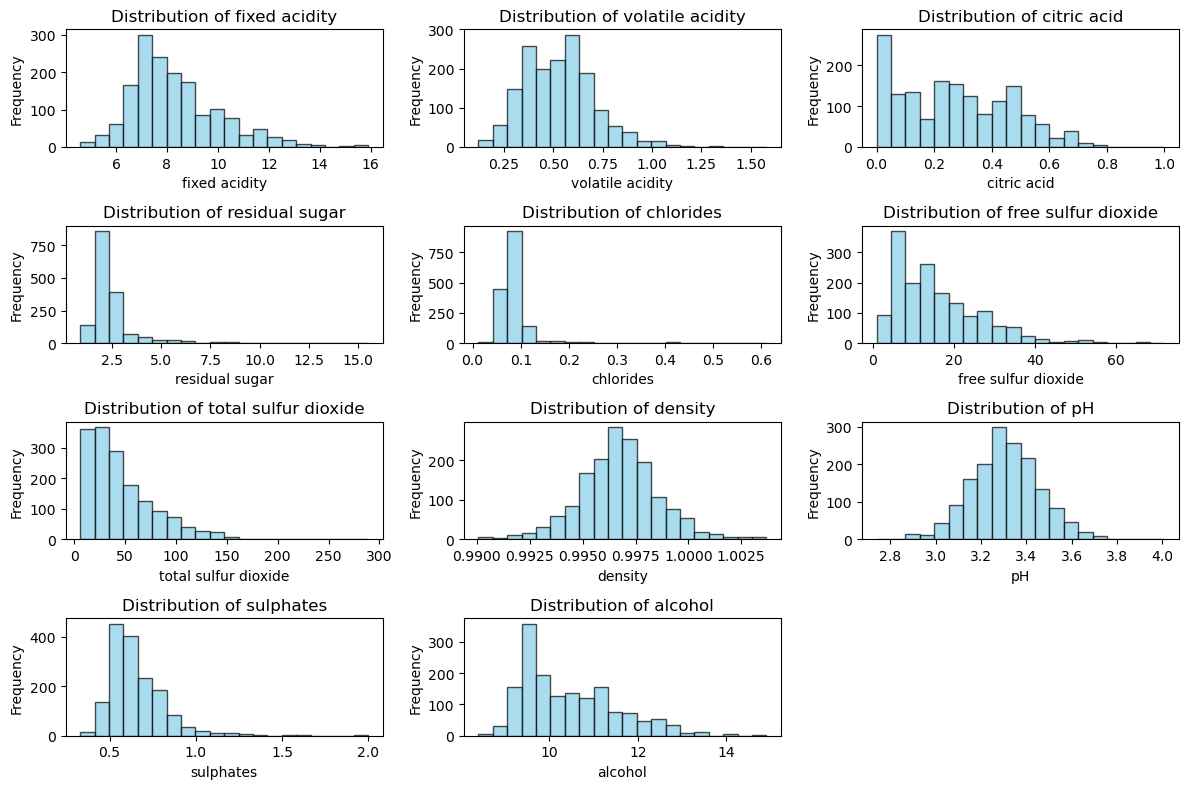

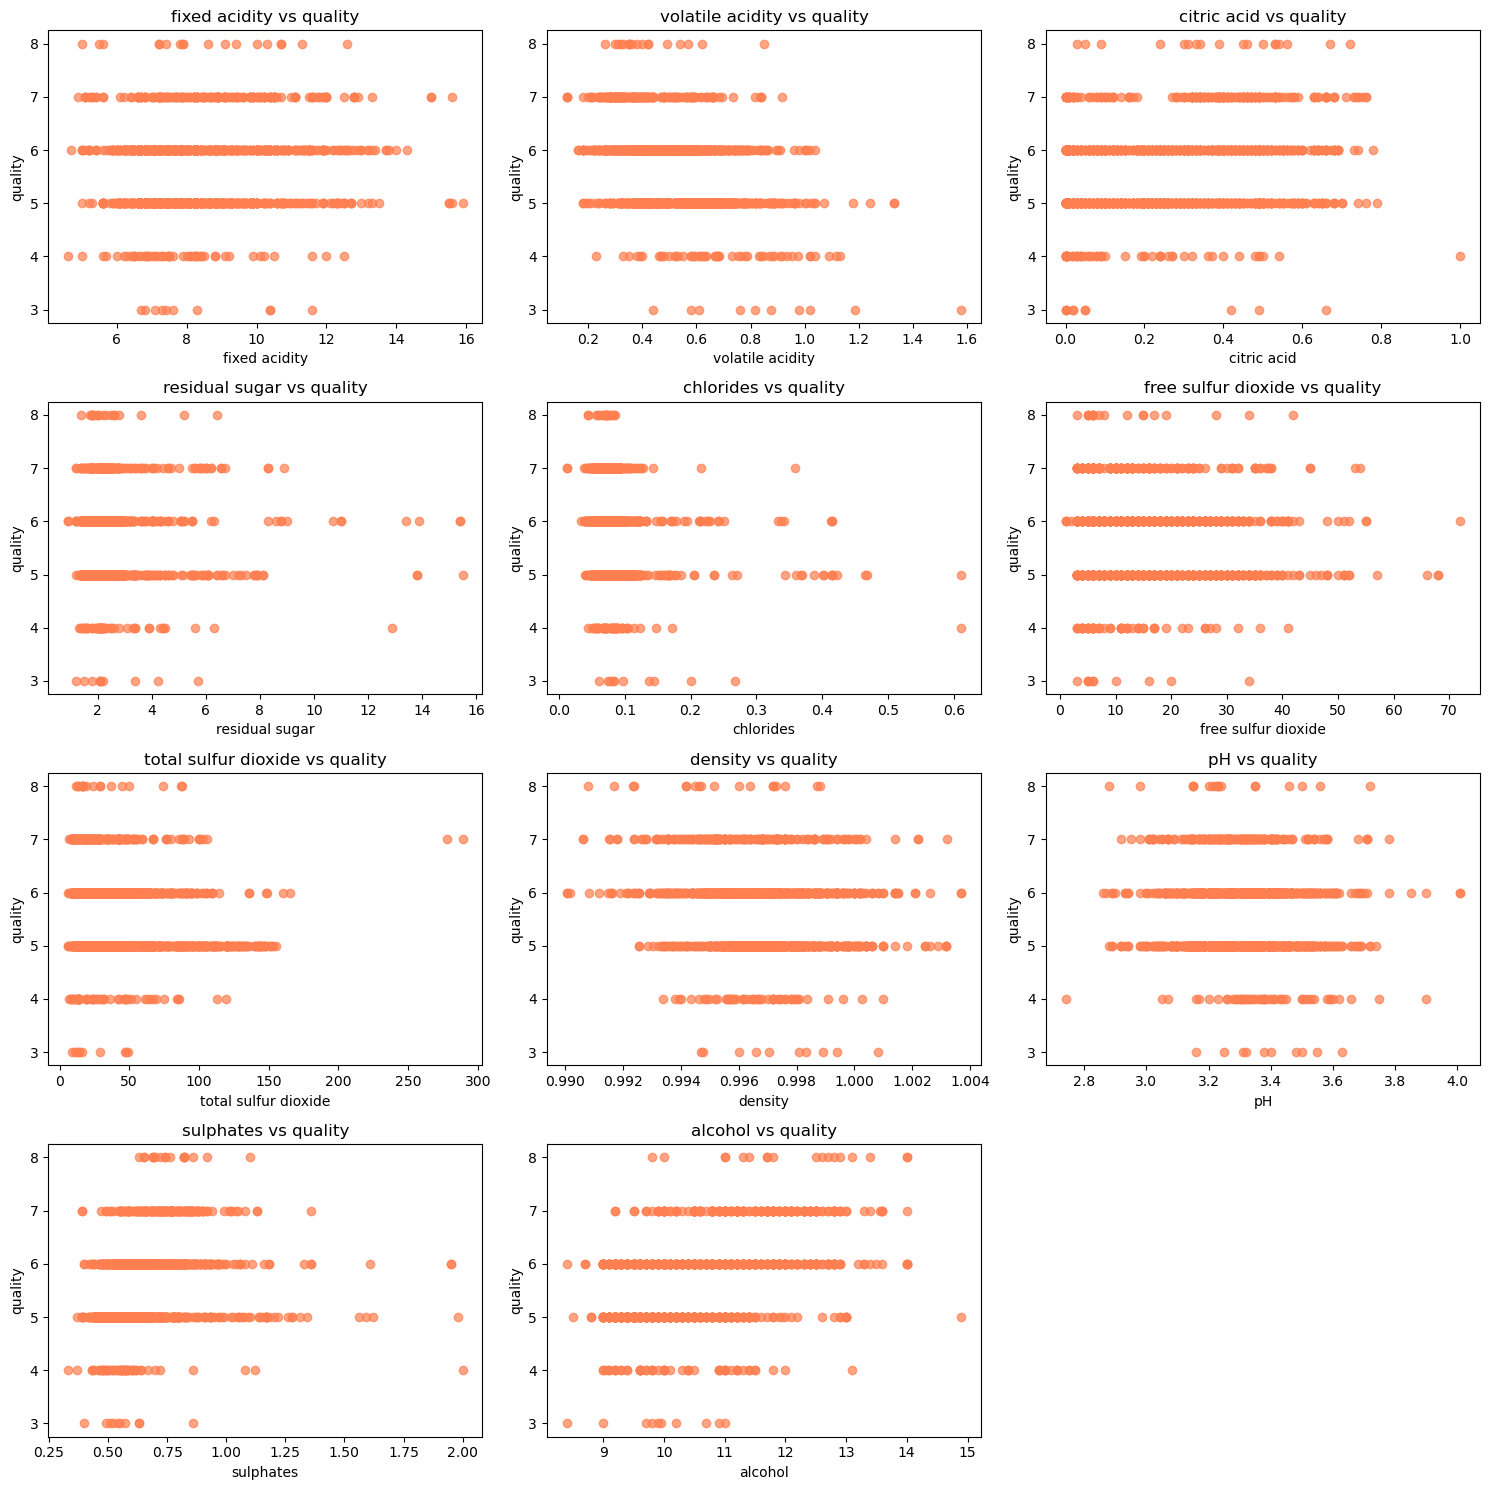

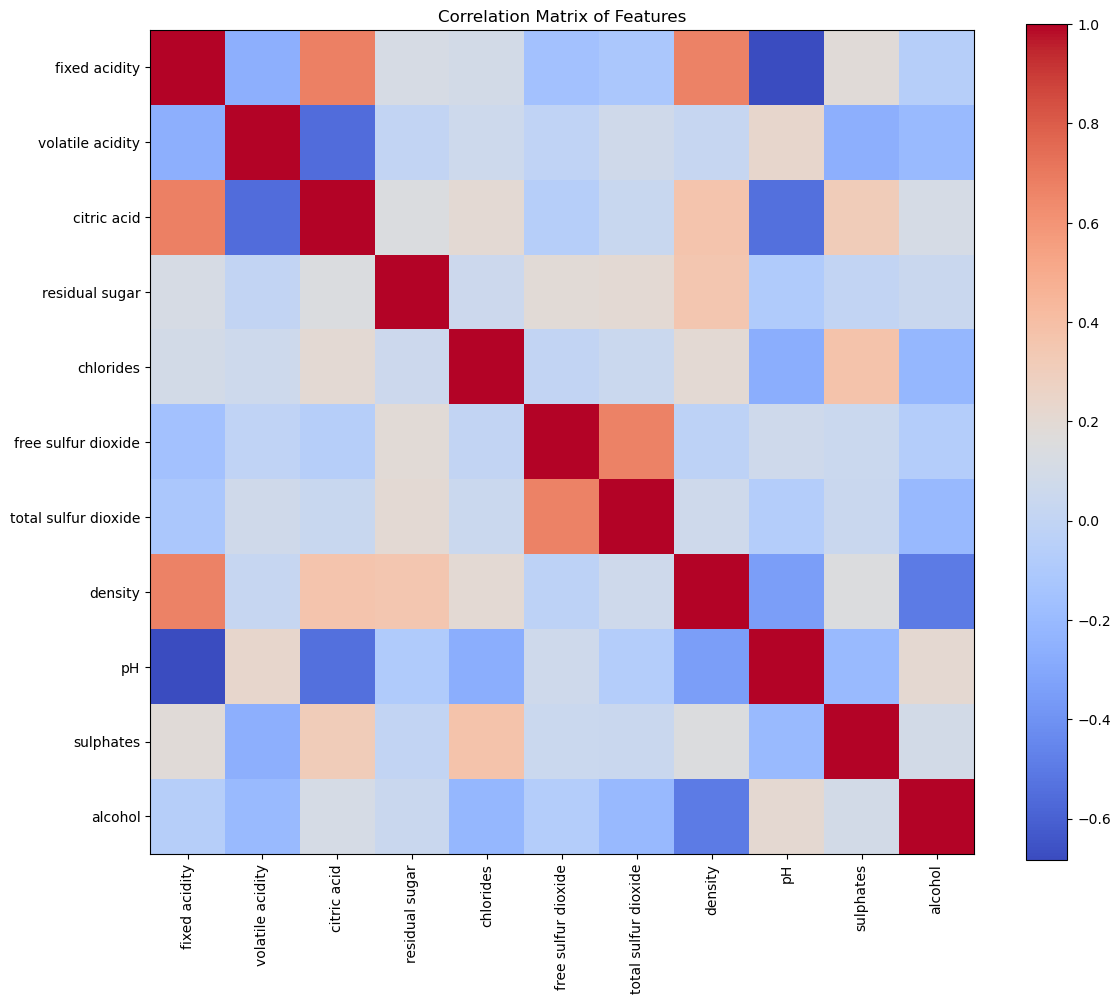

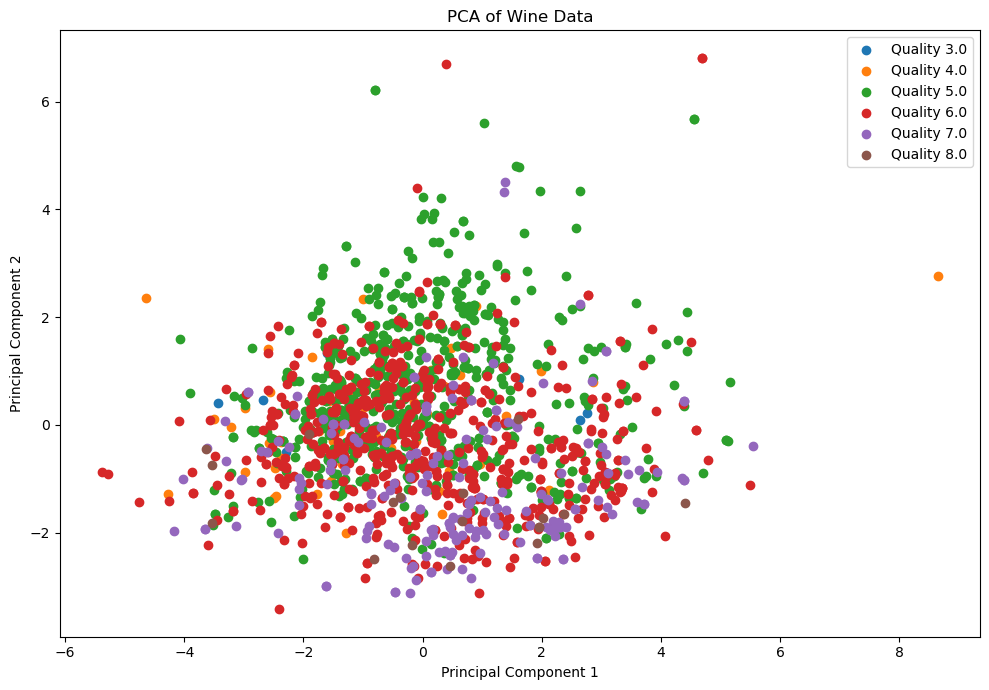

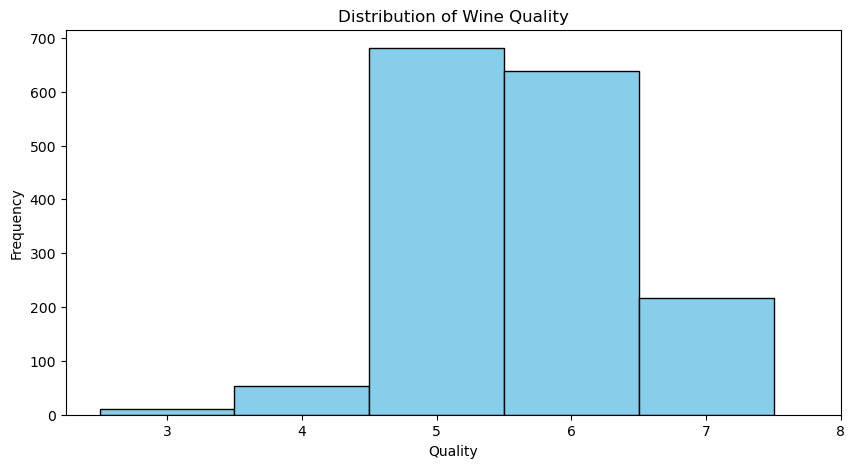

In [82]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
axes = axes.ravel()
for ax, column in zip(axes, column_names[:-1]):
    ax.hist(data[:, column_names.index(column)], bins=20, color="skyblue", edgecolor="black", alpha=0.7)
    ax.set_title(f"Distribution of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")
for ax in axes[len(column_names[:-1]):]:
    ax.axis("off")
plt.tight_layout()
plt.show()

# scatterplots
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
axes = axes.ravel()
for ax, column in zip(axes, column_names[:-1]):
    ax.scatter(data[:, column_names.index(column)], y, alpha=0.7, color="coral")
    ax.set_title(f"{column} vs quality")
    ax.set_xlabel(column)
    ax.set_ylabel("quality")
for ax in axes[len(column_names[:-1]):]:
    ax.axis("off")
plt.tight_layout()
plt.show()

# correlation matrix
correlation_matrix = np.corrcoef(X.T)
plt.figure(figsize=(12, 10))
plt.imshow(correlation_matrix, cmap="coolwarm", interpolation="none")
plt.colorbar()
plt.title("Correlation Matrix of Features")
plt.xticks(ticks=np.arange(X.shape[1]), labels=column_names[:-1], rotation=90)
plt.yticks(ticks=np.arange(X.shape[1]), labels=column_names[:-1])
plt.tight_layout()
plt.show()

# PCA visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(10, 7))
for label in np.unique(y_encoded):
    plt.scatter(
        X_pca[y_encoded == label, 0],
        X_pca[y_encoded == label, 1],
        label=f"Quality {label_encoder.inverse_transform([label])[0]}",
    )
plt.title("PCA of Wine Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()

# quality distribution
plt.figure(figsize=(10, 5))
plt.hist(y, bins=np.arange(y.min(), y.max() + 1), align="left", color="skyblue", edgecolor="black")
plt.title("Distribution of Wine Quality")
plt.xlabel("Quality")
plt.ylabel("Frequency")
plt.xticks(np.arange(y.min(), y.max() + 1))
plt.show()

# Step 4.1: SVM implementation

Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.11      0.09      0.10        11
           2       0.70      0.72      0.71       136
           3       0.62      0.62      0.62       128
           4       0.62      0.60      0.61        40
           5       0.00      0.00      0.00         3

    accuracy                           0.63       320
   macro avg       0.34      0.34      0.34       320
weighted avg       0.62      0.63      0.63       320



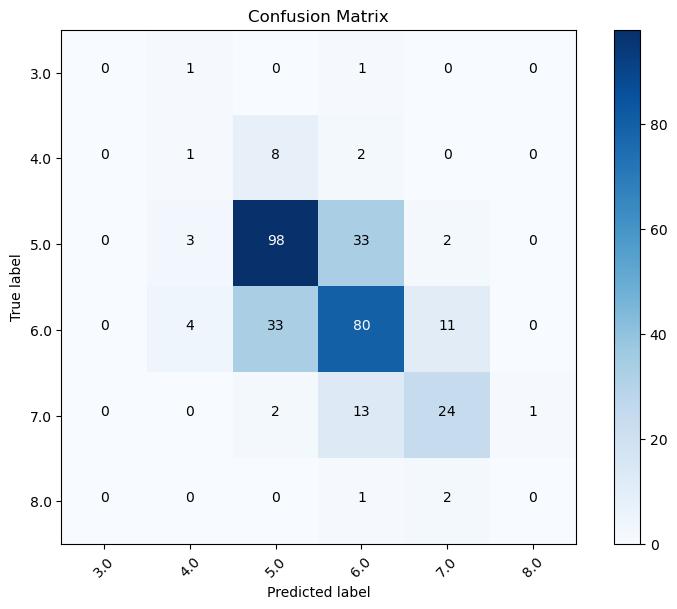

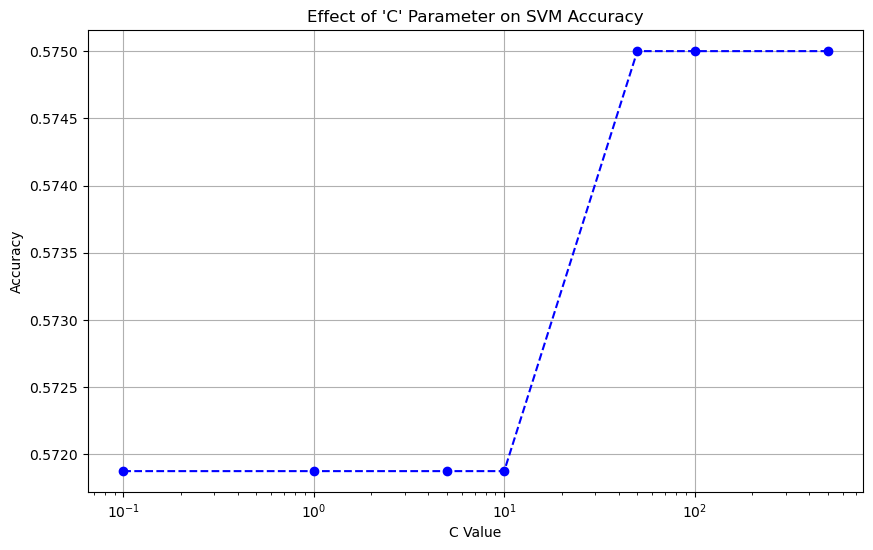

In [40]:
param_grid_svm = {"C": [0.1, 1, 10, 50, 100], "kernel": ["linear", "rbf", "sigmoid", "poly"], "gamma": ["scale", "auto"]}
svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5, scoring="accuracy")
svm.fit(X_train, y_train)
y_pred_svm = svm.best_estimator_.predict(X_test)
print("Best parameters for SVM:", svm.best_params_)
print("Classification Report for SVM:")
print(classification_report(y_test, y_pred_svm, zero_division=0))

# confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

conf_matrix = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(conf_matrix, classes=[str(c) for c in label_encoder.classes_], title="Confusion Matrix")

# effect of 'C' on Accuracy
c_values = [0.1, 1, 5, 10, 50, 100, 500]
accuracies = []
for c in c_values:
    svm_model = SVC(C=c, kernel="linear", random_state=42)
    svm_model.fit(X_train, y_train)
    y_pred = svm_model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(c_values, accuracies, marker="o", linestyle="--", color="b")
plt.title("Effect of 'C' Parameter on SVM Accuracy")
plt.xlabel("C Value")
plt.ylabel("Accuracy")
plt.xscale("log")
plt.grid()
plt.show()

# Step 4.2: ANN implementation

C:\Users\kzahm\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kzahm\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kzahm\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kzahm\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\kzahm\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

Best parameters for ANN:
Activation: tanh, Alpha: 1e-05, Learning Rate: 0.1
Classification Report for ANN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.25      0.18      0.21        11
           2       0.69      0.75      0.72       136
           3       0.60      0.56      0.58       128
           4       0.51      0.53      0.52        40
           5       0.33      0.33      0.33         3

    accuracy                           0.62       320
   macro avg       0.40      0.39      0.39       320
weighted avg       0.61      0.62      0.61       320



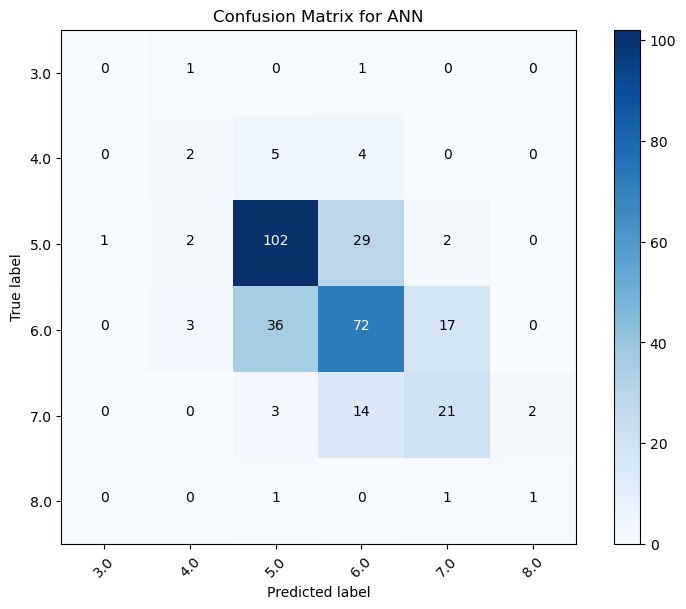

In [64]:
activation = ['identity', 'logistic', 'tanh', 'relu']
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
learning_rate = [0.001, 0.01, 0.1, 1, 10]
scores = np.zeros((len(activation), len(alpha), len(learning_rate)))

for ind1, act in enumerate(activation):
    for ind2, alp in enumerate(alpha):
        for ind3, lr in enumerate(learning_rate):
            clf = MLPClassifier(random_state=42, max_iter=800, activation=act, alpha=alp, learning_rate_init=lr)
            clf.fit(X_train, y_train)
            scores[ind1][ind2][ind3] = clf.score(X_test, y_test)

max_index = np.argmax(scores)
max_index_3d = np.unravel_index(max_index, scores.shape)

best_activation = activation[max_index_3d[0]]
best_alpha = alpha[max_index_3d[1]]
best_learning_rate = learning_rate[max_index_3d[2]]

print("Best parameters for ANN:")
print(f"Activation: {best_activation}, Alpha: {best_alpha}, Learning Rate: {best_learning_rate}")

# Train ANN with best parameters
best_ann = MLPClassifier(random_state=10, max_iter=800, activation=best_activation, alpha=best_alpha, learning_rate_init=best_learning_rate)
best_ann.fit(X_train, y_train)

# Make predictions
y_pred_ann = best_ann.predict(X_test)

# Classification Report for ANN
print("Classification Report for ANN:")
print(classification_report(y_test, y_pred_ann, zero_division=0))

# Confusion Matrix for ANN
conf_matrix_ann = confusion_matrix(y_test, y_pred_ann)
plot_confusion_matrix(conf_matrix_ann, classes=[str(c) for c in label_encoder.classes_], title="Confusion Matrix for ANN")

# Step 4.3: KNN implementation

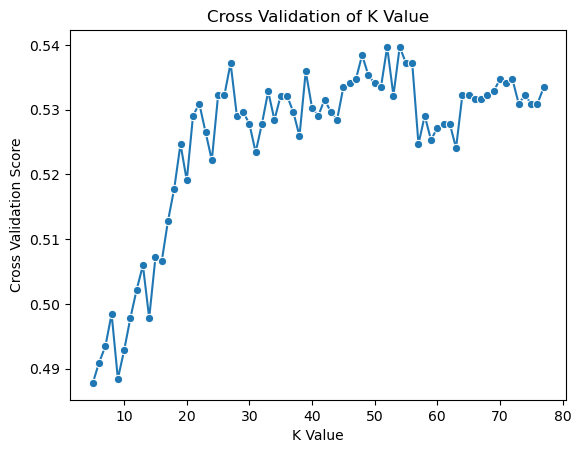

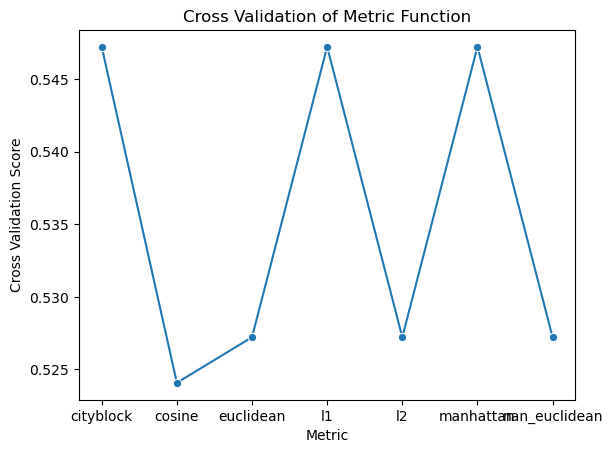

Best parameters for KNN:
K neighbors: 54, Metric: cityblock
Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.74      0.74      0.74       136
           3       0.59      0.72      0.65       128
           4       0.64      0.45      0.53        40
           5       1.00      0.33      0.50         3

    accuracy                           0.66       320
   macro avg       0.50      0.37      0.40       320
weighted avg       0.64      0.66      0.64       320



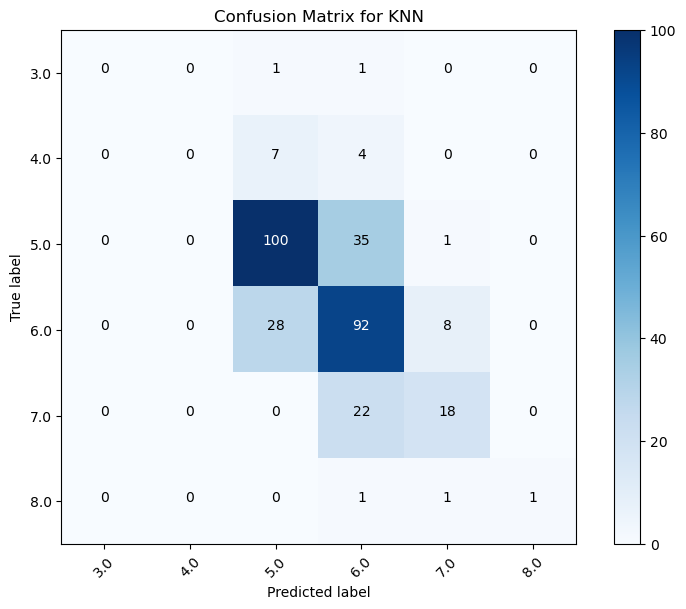

In [84]:
#-----KNN IMPLEMENTATION-----
metrics = ["cityblock","cosine","euclidean","l1","l2","manhattan","nan_euclidean"]
k_values = range(5,2*int(np.floor(np.sqrt((len(y))))))

scaler = StandardScaler()
S = scaler.fit_transform(X)

# Cross validation to determine ideal k value
scores = []
for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
        score = cross_val_score(knn, X, y, cv=5)
        scores.append(np.mean(score))
plt.figure()
plt.title("Cross Validation of K Value")
plt.xlabel("K Value")
plt.ylabel("Cross Validation Score")
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.show()
best_index = np.argmax(scores)
best_k = k_values[best_index]

# Cross validation to determine ideal metric function
mscores = []
for m in metrics:
    knn = KNeighborsClassifier(n_neighbors=best_k,metric=m)
    score = cross_val_score(knn, X, y, cv=5)
    mscores.append(np.mean(score))
plt.figure()
plt.title("Cross Validation of Metric Function")
plt.xlabel("Metric")
plt.ylabel("Cross Validation Score")
sns.lineplot(x=metrics,y=mscores,marker='o')
plt.show()
best_index = np.argmax(mscores)
best_metric = metrics[best_index]

print("Best parameters for KNN:")
print(f"K neighbors: {best_k}, Metric: {best_metric}")

# Run KNN Algorithm with best parameters
best_knn = KNeighborsClassifier(n_neighbors=best_k,metric=best_metric, weights="distance")
best_knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = best_knn.predict(X_test)

# Classification Report for KNN
print("Classification Report for KNN:")
print(classification_report(y_test, y_pred_knn, zero_division=0))

# Confusion Matrix for KNN
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(conf_matrix_knn, classes=[str(c) for c in label_encoder.classes_], title="Confusion Matrix for KNN")

# Conclusion, Results, Comparison